In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split

# Dataset

In [130]:
data = pd.read_csv('sonar.all-data', header=None)
data.shape

(208, 61)

Let's separate the data into two classes, 'rocks' and 'mines'. The attribute `iloc` will be used to drop the class label.

In [26]:
rocks = data[data[60] == 'R'].iloc[:, :-1] 
mines = data[data[60] == 'M'].iloc[:, :-1]

rocks.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094


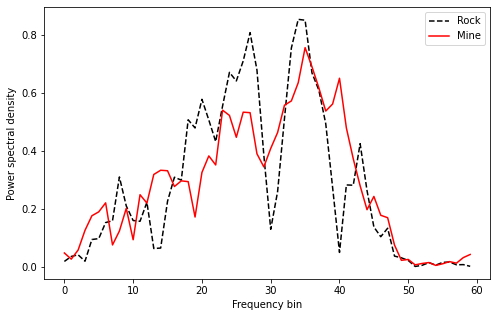

In [40]:
plt.figure(figsize=(8,5))
plt.plot(rocks.values[0], label='Rock', c='black', linestyle='--')
plt.plot(mines.values[0], label='Mine', c='red')
plt.xlabel('Frequency bin')
plt.ylabel('Power spectral density')
plt.legend()
plt.show()

# Re-formatting the data as a tensor

In [133]:
x = data.iloc[:, :-1]

x_tensor = torch.tensor(x.values, dtype=torch.float32)
x_tensor.dtype
#y = data.iloc[:, -1:]

# Split the data into training and testing data. Note that we will not need access to the labels when training the autoencoder.
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

torch.float32

# Building the autoencoder

In [327]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Linear encoder composed of linear layers alternating with sigmoidal activation functions
        # Compress input from sixty features to five features
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(60, 52),
            torch.nn.ReLU(),
            torch.nn.Linear(52, 44),
            torch.nn.ReLU(),
            torch.nn.Linear(44, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 24),
            torch.nn.ReLU(),
            torch.nn.Linear(24, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 5)
        )
        
        # Linear decoder that maps five features back to sixty
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(5, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 24),
            torch.nn.ReLU(),
            torch.nn.Linear(24, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 44),
            torch.nn.ReLU(),
            torch.nn.Linear(44, 52),
            torch.nn.ReLU(),
            torch.nn.Linear(52, 60),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Training the autoencoder

In [377]:
model = AE()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

data_loader = torch.utils.data.DataLoader(x_tensor, batch_size=1, shuffle=False)

epochs = 100
outputs = []
losses = []

for epoch in range(epochs):
    loss = 0
    for batch_features in data_loader:
        
        # Apply the autoencoder:
        reconstruction = model(batch_features)
        
        # Compute the loss:
        train_loss = criterion(reconstruction, batch_features)
        
        # Set gradients to zero:
        optimizer.zero_grad() 
        
        # Compute gradients:
        train_loss.backward()
        
        # Update learnable parameters based on gradient evaluation:
        optimizer.step()
    
        # Add to the loss:
        loss += train_loss.item()
    
        if epoch == epochs-1:
            outputs.append([batch_features, reconstruction])
            
    # Compute the loss averaged over the epoch, then add it to 'losses':
    loss = loss/len(data_loader)
    losses.append(loss)
    
    if (epoch+1) % 5 == 0:
        print("Epoch:{}/{}, loss={}".format(epoch+1, epochs, loss))

Epoch:5/100, loss=0.027935309978112437
Epoch:10/100, loss=0.02338531826255628
Epoch:15/100, loss=0.021312050895246033
Epoch:20/100, loss=0.01981501193726077
Epoch:25/100, loss=0.018569525090592485
Epoch:30/100, loss=0.017466080294420514
Epoch:35/100, loss=0.017147202879781477
Epoch:40/100, loss=0.017006381723779038
Epoch:45/100, loss=0.018000494388755985
Epoch:50/100, loss=0.016714190826930393
Epoch:55/100, loss=0.0164882620257021
Epoch:60/100, loss=0.017142957425676286
Epoch:65/100, loss=0.017106669199375365
Epoch:70/100, loss=0.016718395310677946
Epoch:75/100, loss=0.01628150044416543
Epoch:80/100, loss=0.01619323157277764
Epoch:85/100, loss=0.015959328008578338
Epoch:90/100, loss=0.015781215699882105
Epoch:95/100, loss=0.015706760037573986
Epoch:100/100, loss=0.015747154359884847


# Plotting the loss

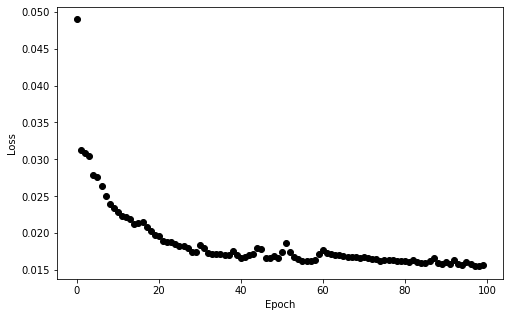

In [378]:
plt.figure(figsize=(8,5))
plt.scatter(np.arange(0, epochs), losses, color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

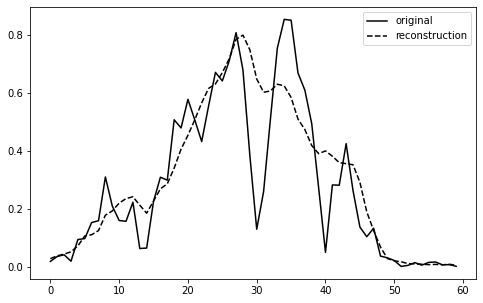

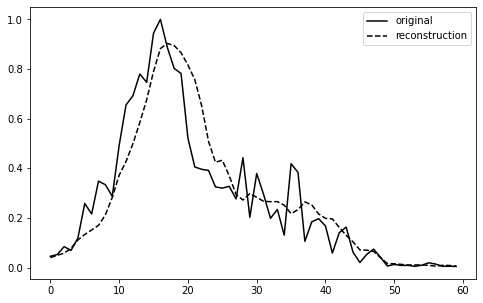

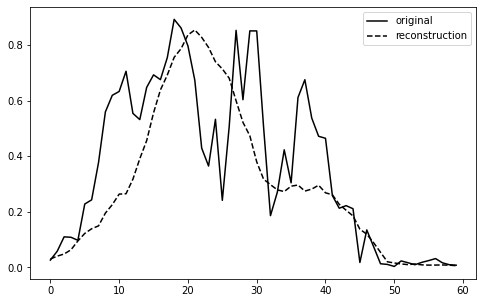

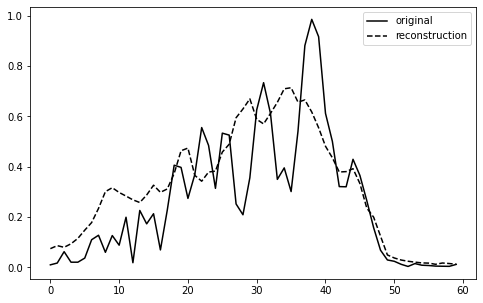

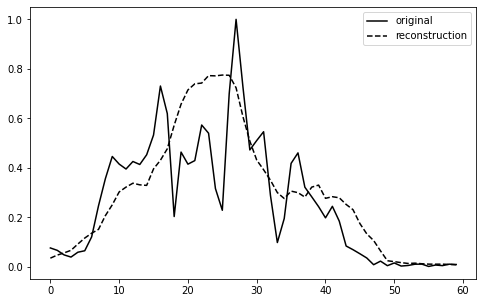

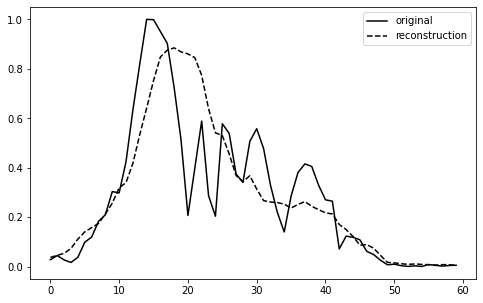

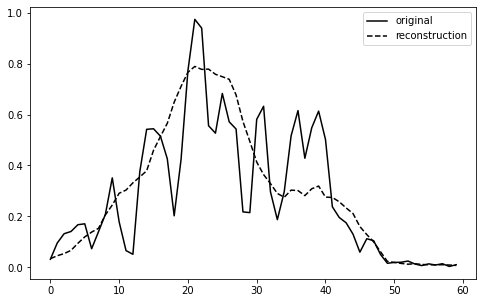

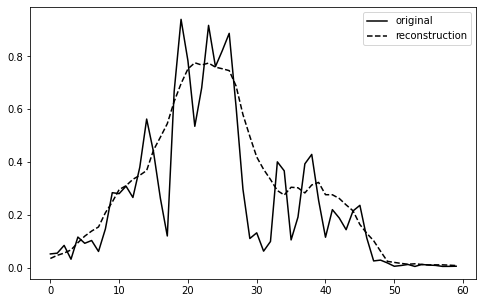

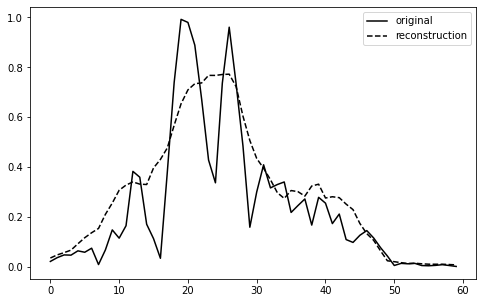

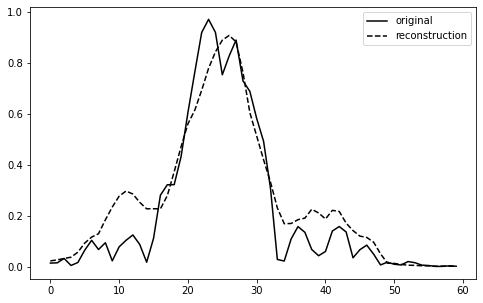

In [379]:
# Example of reconstruction
def compare(sample):
    original, reconstruction = outputs[sample]
    plot = plt.figure(figsize=(8,5))
    plt.plot(original[0].numpy(), label='original', color='black')
    plt.plot(reconstruction[0].detach().numpy(), label='reconstruction', color='black', linestyle='--')
    plt.legend()
    return plot

for i in range(10):
    compare(i)